# Setup

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the model

In [28]:
def g0_sampler():
    return np.random.normal(0, 1)

def f_sampler(theta):
    return np.random.normal(theta, 0.1)

def F_likelihood(theta, x):
    return np.exp(-(theta - x)**2 / (2 * 0.1**2))

In [29]:
def DP_sampler(n, alpha):
    # Sample the thetas
    thetas = []
    for i in range(n):
        u = np.random.uniform()
        if u < alpha / (alpha + i):
            thetas.append(g0_sampler())
        else:
            thetas.append(thetas[np.random.randint(0, i)])
    return thetas

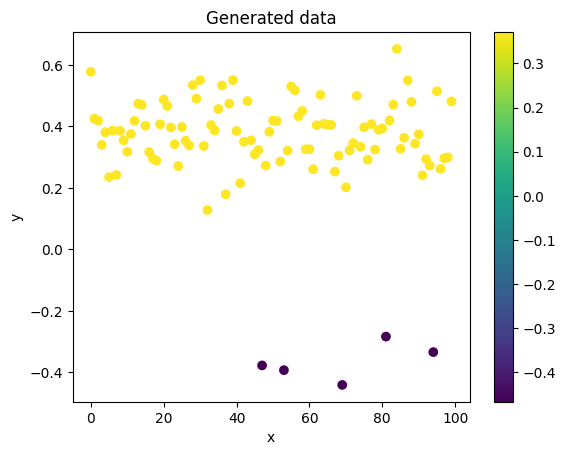

In [31]:
# Generate data
n = 100
alpha = 0.25
thetas = DP_sampler(n, alpha)
y = np.array([f_sampler(theta) for theta in thetas])

# Plot data
plt.figure()
plt.scatter(np.arange(n), y, c=thetas)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# Algorithm 6

In [32]:
def algorithm_6_sample(theta, alpha):
    # Choose wether we sample from existing theta or from g0
    if np.random.rand() < alpha / (len(theta) + alpha):
        # Sample from g0
        theta = g0_sampler()
    else:
        # Sample from existing theta
        theta = np.random.choice(theta)

    return theta

def algorithm_6(N, y, alpha):
    n = len(y)
    thetas = np.zeros((N+1, n))
    lhs = np.zeros((N+1, n))
    lhs[0] = np.array([F_likelihood(thetas[0, j], y[j]) for j in range(n)])

    for i in range(1, N+1):
        theta = thetas[i-1].copy()
        lh = lhs[i-1].copy()
        for j in range(n):
            theta_proposal = algorithm_6_sample(theta[np.arange(n) != j], alpha)
            lh_proposal = F_likelihood(theta_proposal, y[j])

            # Compute acceptance probability
            alpha = min(1, lh_proposal / lh[j])

            # Accept or reject
            if np.random.rand() < alpha:
                theta[j] = theta_proposal
                lh[j] = lh_proposal
            
        thetas[i] = theta.copy()
        lhs[i] = lh.copy()

    return thetas, lhs


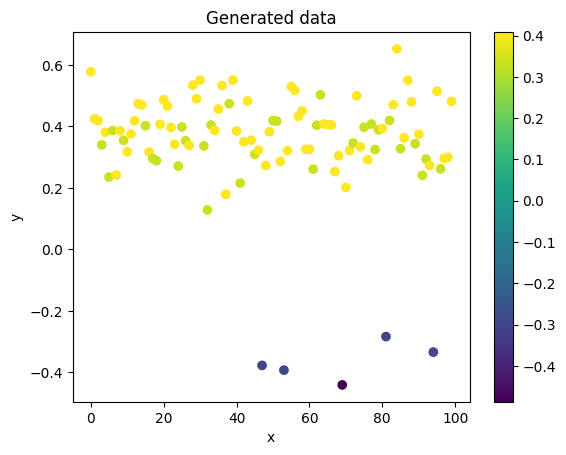

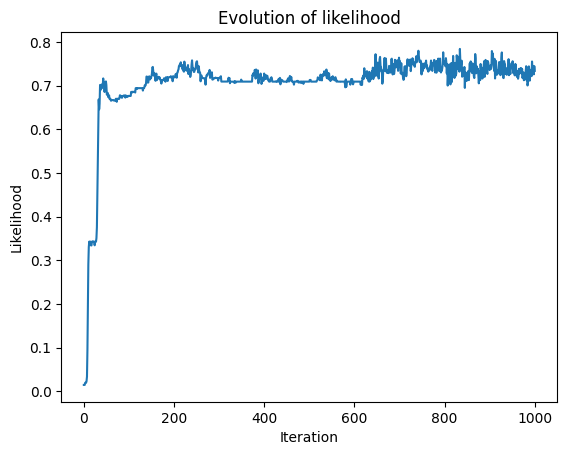

In [34]:
n = 100
N = 1000
alpha = 0.25

thetas, lhs = algorithm_6(N, y, alpha)
theta = thetas[-1]

# plot y coloured by theta
plt.figure()
plt.scatter(np.arange(n), y, c=theta)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# plot evolution of lh
plt.figure()
plt.plot(np.mean(lhs, axis=1))
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()

# Algorithme 7

In [10]:

def find_unused_cluster(c):
    # Find the first unused cluster
    for k in range(len(c)):
        if np.sum(c == k) == 0:
            return k

    raise Exception("No unused cluster found")


def algorithm_7(N, y, alpha):
    n = len(y)
    cs = np.zeros((N+1, n), dtype=int)
    phis = np.zeros((N+1, n), dtype=float)
    lhs = np.zeros((N+1, n), dtype=float)
    lhs[0] = np.array([F_likelihood(thetas[0, j], y[j]) for j in range(len(y))])

    for i in range(1, N+1):
        c = cs[i-1].copy()
        phi = phis[i-1].copy()
        lh = lhs[i-1].copy()

        for j in range(n):
            # test if c[j] is a singleton
            if np.sum(c == c[j]) == 1:
                # Choose c[j] from c[-j] with probability n_i / (n - 1)
                c_proposal = np.random.choice(c[c != c[j]])
                lh_proposal = F_likelihood(phi[c_proposal], y[j])

                # Compute acceptance probability
                alpha = min(1, ((n-1) / alpha) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < alpha:
                    c[j] = c_proposal
                    phi[c[j]] = phi[c_proposal]
                    lh[j] = lh_proposal

            else:
                c_proposal = find_unused_cluster(c)
                phi_proposal = g0_sampler()
                lh_proposal = F_likelihood(phi_proposal, y[j])

                # Compute acceptance probability
                alpha = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < alpha:
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
                    lh[j] = lh_proposal

        for j in range(n):
            # test if c[j] is not a singleton
            if np.sum(c == c[j]) > 1:

                # Compute transition probas
                lh_proposals = np.zeros(len(c))
                for c_unique in np.unique(c):
                    lh_proposals[c == c_unique] = F_likelihood(phi[c_unique], y[j])
                lh_proposals[j] = 0

                c[j] = np.random.choice(c, p=lh_proposals / np.sum(lh_proposals))
                lh[j] = lh_proposals[c[j]]

        for c_unique in np.unique(c):
            phi[c_unique] = np.random.normal(np.mean(y[c == c_unique]), 0.1)

        cs[i] = c.copy()
        phis[i] = phi.copy()
        lhs[i] = lh.copy()

    return cs, phis, lhs

C:\Users\Marius\AppData\Local\Temp\ipykernel_29176\1949343622.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])
C:\Users\Marius\AppData\Local\Temp\ipykernel_29176\1949343622.py:43: RuntimeWarning: invalid value encountered in scalar divide
  alpha = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])
C:\Users\Marius\AppData\Local\Temp\ipykernel_29176\1949343622.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(1, ((n-1) / alpha) * lh_proposal / lh[j])
C:\Users\Marius\AppData\Local\Temp\ipykernel_29176\1949343622.py:29: RuntimeWarning: overflow encountered in scalar divide
  alpha = min(1, ((n-1) / alpha) * lh_proposal / lh[j])
C:\Users\Marius\AppData\Local\Temp\ipykernel_29176\1949343622.py:43: RuntimeWarning: overflow encountered in scalar divide
  alpha = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])
C:\Users\Marius\AppData\Local\Temp\ipykernel_29176\1949343622.py:29: RuntimeWarnin

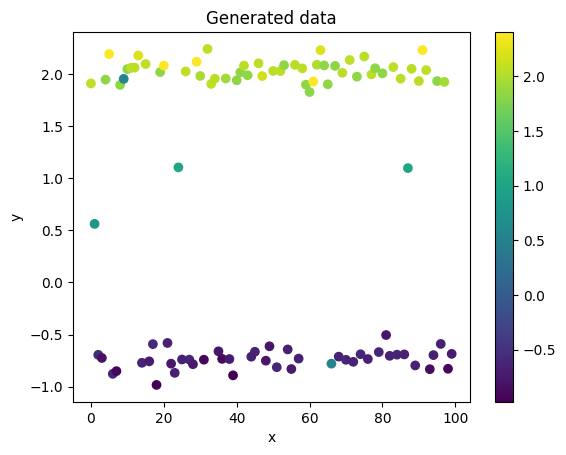

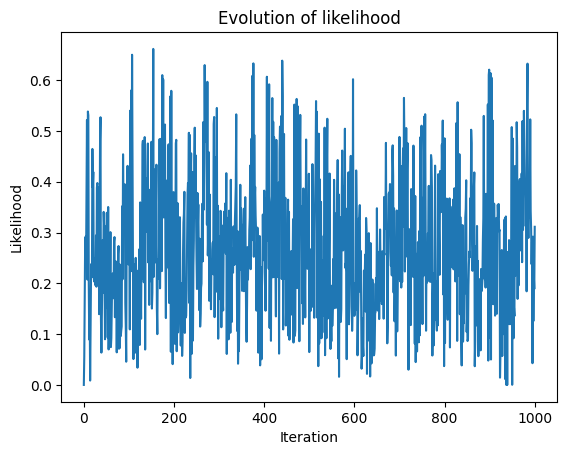

In [11]:
# Run algorithm 7
n = 100
N = 1000
alpha = 0.25

cs, phis, lhs = algorithm_7(N, y, alpha)
c = cs[-1]
phi = phis[-1]

# plot y coloured by theta
plt.figure()
plt.scatter(np.arange(n), y, c=phi[c])
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# plot evolution of lh
plt.figure()
plt.plot(np.mean(lhs, axis=1))
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()